In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

p = sns.color_palette()


In [3]:
print '# File Sizes'
for f in os.listdir('../data'):
    print f.ljust(30) + str(round(os.path.getsize('../data/' + f) / 1000000, 2)) + 'MB'

# File Sizes
.DS_Store                     0.0MB
clicks_test.csv               506.0MB
clicks_train.csv              1486.0MB
documents_categories.csv      118.0MB
documents_entities.csv        324.0MB
documents_topics.csv          339.0MB
page_views_sample.csv         454.0MB
promoted_content.csv          13.0MB
sample_submission.csv         273.0MB


#### Let's start by looking at clicks train and clicks

Each display set has a certian number of adverts, let's see if the distribution is the same in both files

In [4]:
df_train = pd.read_csv('../data/clicks_train.csv')
df_test = pd.read_csv('../data/clicks_test.csv')

In [7]:
sizes_train = df_train.groupby('display_id')['ad_id'].count().value_counts()
sizes_test = df_test.groupby('display_id')['ad_id'].count().value_counts()

sizes_train = sizes_train / np.sum(sizes_train)
sizes_test = sizes_test / np.sum(sizes_test)


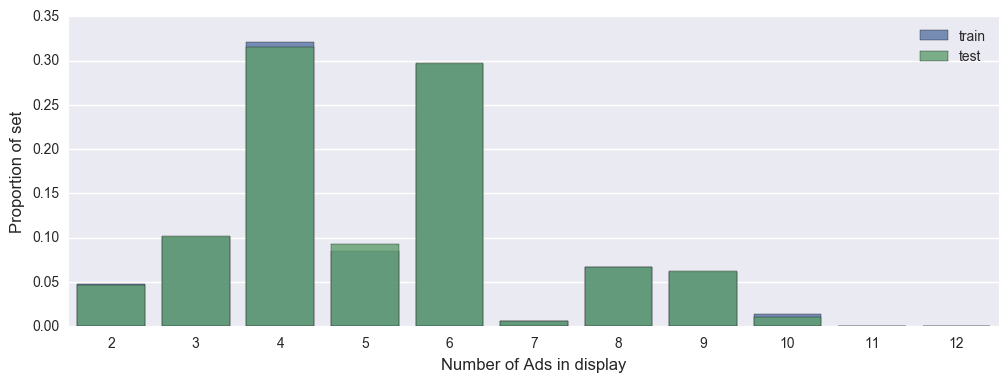

In [9]:
plt.figure(figsize=(12,4))
sns.barplot(sizes_train.index, sizes_train, alpha = 0.8, color = p[0], label = 'train')
sns.barplot(sizes_test.index, sizes_test, alpha = 0.8, color = p[1], label = 'test')

plt.legend()
plt.xlabel('Number of Ads in display', fontsize=12)
plt.ylabel('Proportion of set', fontsize=12)

#### He calls this a perfect split, so I'll go with it. Now let's looks at which adverts are often used and which are not.

In [11]:
ad_usage_train = df_train.groupby('ad_id')['ad_id'].count()

for i in [2,10,50,100,1000]:
    print 'Ads that appear less than {} times: {}%'.format(i, round((ad_usage_train < i).mean() * 100, 2))

Ads that appear less than 2 times: 22.69%
Ads that appear less than 10 times: 61.74%
Ads that appear less than 50 times: 86.93%
Ads that appear less than 100 times: 91.04%
Ads that appear less than 1000 times: 97.45%


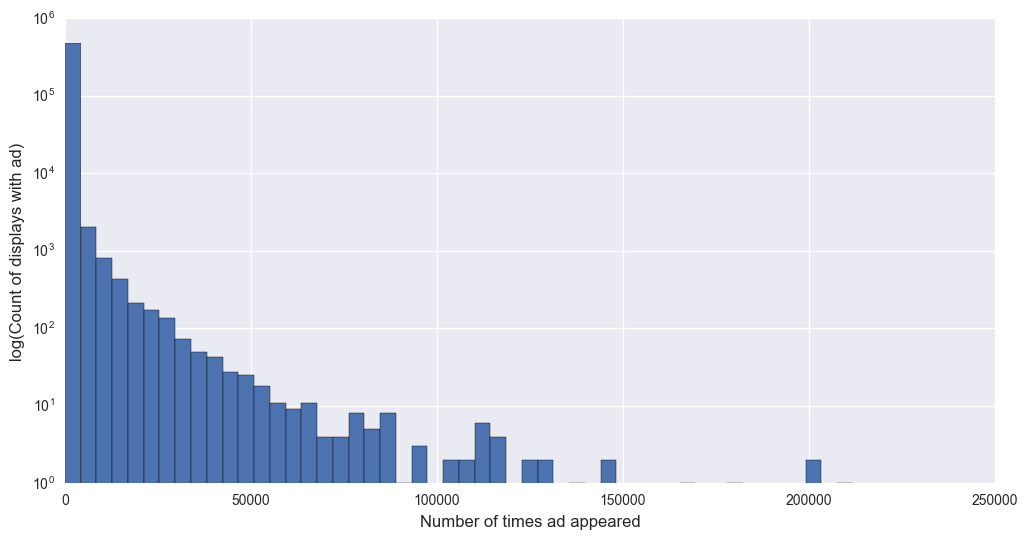

In [13]:
plt.figure(figsize=(12,6))
plt.hist(ad_usage_train.values, bins = 50, log = True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)
plt.show()

#### Many ads only appear a few times in the training set. So we're going to want to use not just info on ad itself but also the display to predict clicks

#### How many ads are in the test set are not in the training set

In [14]:
df_train.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


In [15]:
df_test.head()

,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754
3,16874594,170392
4,16874594,172888


In [17]:
from __future__ import division
ad_prop = len(set(df_test.ad_id.unique()).intersection(df_train.ad_id.unique())) / len(df_test.ad_id.unique())

print 'Proportion of ads in test set that are also in training: {}%'.format(round(ad_prop * 100, 2))

Proportion of ads in test set that are also in training: 82.87%


### Events (let's see if we can load)

In [19]:
try:del df_train,df_test # do some gc
except:pass;gc.collect()

events = pd.read_csv('../data/events.csv')
print('Shape:', events.shape)
print('Columns', events.columns.tolist())
events.head()

/Users/paulsingman/projects/koutbrain/kenv/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


('Shape:', (23120126, 6))
('Columns', ['display_id', 'uuid', 'document_id', 'timestamp', 'platform', 'geo_location'])


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


In [21]:
plat = events.platform.value_counts()

print plat

print '\nUnique platform values: {}'.format(events.platform.unique())

2     10684579
1      8747280
3      3032907
2       291699
1       279988
3        83668
\N           5
Name: platform, dtype: int64

Unique platform values: [3 2 1 '2' '1' '3' '\\N']


#### Let's convert all the platforms types to string

In [23]:
events.platform = events.platform.astype(str)
plat = events.platform.value_counts()

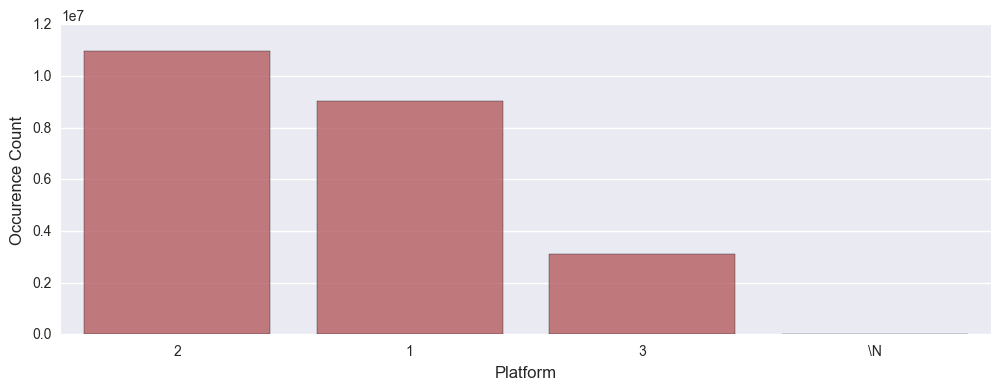

In [24]:
plt.figure(figsize=(12,4))
sns.barplot(plat.index, plat.values, alpha=0.8, color = p[2])
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Occurence Count', fontsize=12)

It's unclear what platform means, but my guess is phone or tablet. Something like that

Let's take a look at UUID next

In [25]:
uuid_counts = events.groupby('uuid')['uuid'].count().sort_values()

print uuid_counts.tail()

uuid
ef7761dd22277c    38
45d23867dbe3b3    38
c0bd502c7a479f    42
2759b057797f02    46
b88553e3a2aa29    49
Name: uuid, dtype: int64


In [26]:
for i in [2,5,10]:
    print 'users that appear less than {} times: {}%'.format(i, round((uuid_counts < i).mean() * 100, 2))

users that appear less than 2 times: 88.42%
users that appear less than 5 times: 99.51%
users that appear less than 10 times: 99.96%


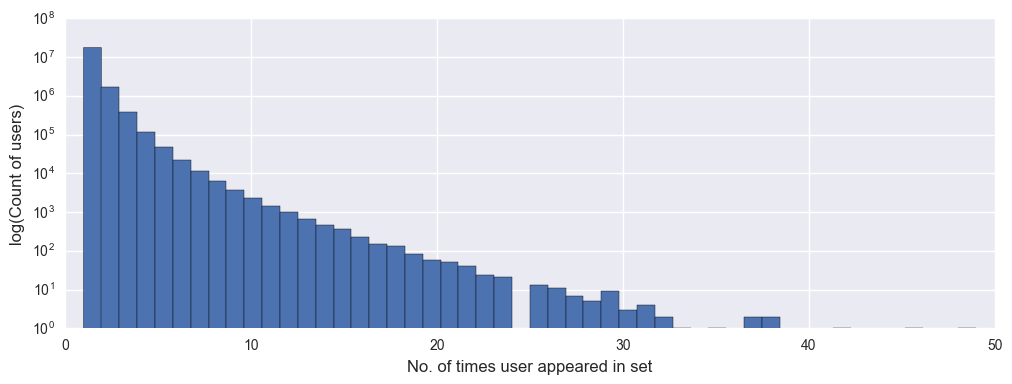

In [28]:
plt.figure(figsize=(12,4))
plt.hist(uuid_counts.values, bins=50, log=True)
plt.xlabel('No. of times user appeared in set', fontsize=12)
plt.ylabel('log(Count of users)', fontsize=12)
plt.show()

#### Similar distribution as ads, many unique users. Would like to look at whether user clicks same ad twice, and if users are in both training and testing